In [52]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [53]:
df = pd.read_excel("transactions.xlsx")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,211075.91,C1540894701,0.00,0.00,C564160838,930082.81,1254956.07,0
1,5,CASH_OUT,10119.47,C213063852,10119.47,0.00,C922511709,0.00,10119.47,1
2,1,PAYMENT,1684.81,C1481594086,297.00,0.00,M1569435561,0.00,0.00,0
3,26,CASH_OUT,37065.55,C281192595,37065.55,0.00,C514736179,1396327.66,1433393.21,1
4,1,PAYMENT,7707.44,C1108889615,99827.00,92119.56,M1275028674,0.00,0.00,0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            521 non-null    int64  
 1   type            521 non-null    object 
 2   amount          521 non-null    float64
 3   nameOrig        521 non-null    object 
 4   oldbalanceOrg   521 non-null    float64
 5   newbalanceOrig  521 non-null    float64
 6   nameDest        521 non-null    object 
 7   oldbalanceDest  521 non-null    float64
 8   newbalanceDest  521 non-null    float64
 9   isFraud         521 non-null    int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 40.8+ KB


In [55]:
df.shape

(521, 10)

In [56]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [57]:
# Handle missing values
df.fillna(0, inplace=True)


In [58]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
encoder = LabelEncoder()
df['type'] = encoder.fit_transform(df['type'])
df['nameOrig'] = encoder.fit_transform(df['nameOrig'])
df['nameDest'] = encoder.fit_transform(df['nameDest'])

In [59]:
#Feature Engineering

df['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['amount_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

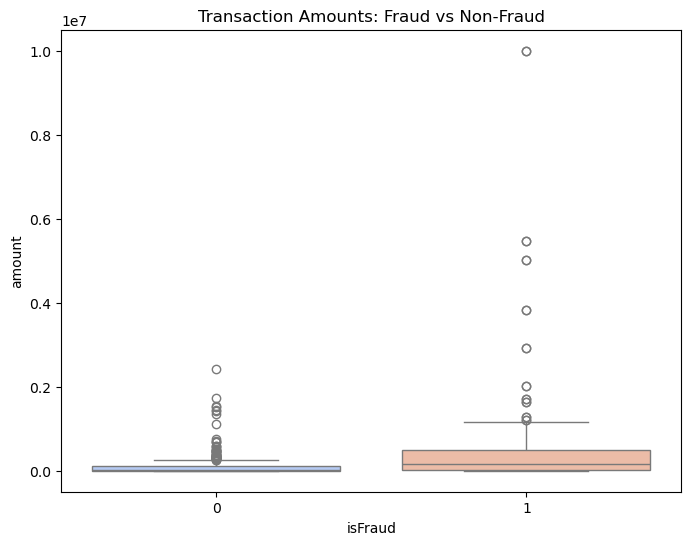

In [61]:
plt.figure(figsize=(8,6))
sns.boxplot(x='isFraud', y='amount', data=df, palette='coolwarm')
plt.title("Transaction Amounts: Fraud vs Non-Fraud")
plt.show()

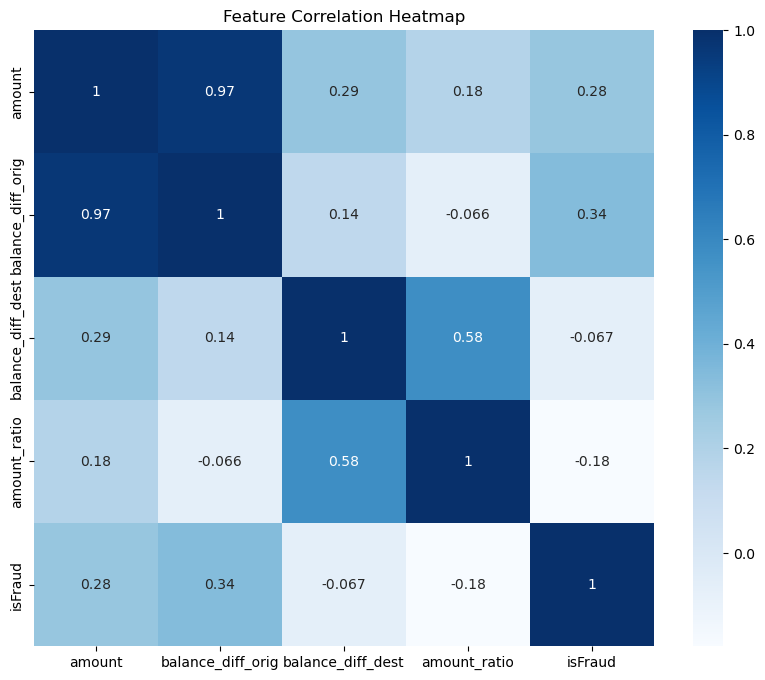

In [62]:
plt.figure(figsize=(10,8))
sns.heatmap(df[['amount','balance_diff_orig','balance_diff_dest','amount_ratio','isFraud']].corr(),
            annot=True, cmap='Blues')
plt.title("Feature Correlation Heatmap")
plt.show()


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Target variable
y = df['isFraud']

# Feature set (drop non-useful columns)
X = df.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)

# Encode categorical column
X['type'] = X['type'].astype('category').cat.codes


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [64]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

Accuracy: 0.9238095238095239
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        73
           1       1.00      0.75      0.86        32

    accuracy                           0.92       105
   macro avg       0.95      0.88      0.90       105
weighted avg       0.93      0.92      0.92       105



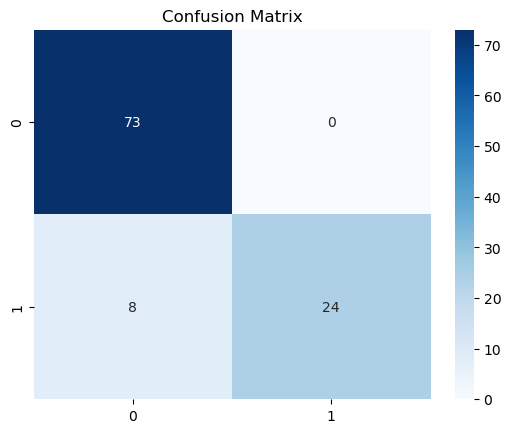

In [65]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [66]:
%%writefile app1.py

import streamlit as st
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------------------------
# Streamlit Page Config
# ---------------------------
st.set_page_config(page_title="Fraud Detection App", layout="wide")

st.title("💳 Transaction Fraud Detection")
st.write("Upload transaction data and train a Logistic Regression model to detect fraud.")

# ---------------------------
# File Upload
# ---------------------------
uploaded_file = st.file_uploader("Upload transactions Excel file", type=["xlsx"])

if uploaded_file is not None:
    df = pd.read_excel(uploaded_file)
    st.subheader("📊 Raw Dataset")
    st.dataframe(df.head())

    # ---------------------------
    # Data Preprocessing
    # ---------------------------
    df.fillna(0, inplace=True)

    encoder = LabelEncoder()
    df['type'] = encoder.fit_transform(df['type'])
    df['nameOrig'] = encoder.fit_transform(df['nameOrig'])
    df['nameDest'] = encoder.fit_transform(df['nameDest'])

    # Feature Engineering
    df['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
    df['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
    df['amount_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)

    st.subheader("🛠 Feature Engineered Data")
    st.dataframe(df.head())

    # ---------------------------
    # Train-Test Split
    # ---------------------------
    y = df['isFraud']
    X = df.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)

    X['type'] = X['type'].astype('category').cat.codes

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # ---------------------------
    # Model Training
    # ---------------------------
    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # ---------------------------
    # Evaluation
    # ---------------------------
    st.subheader("📈 Model Performance")

    acc = accuracy_score(y_test, y_pred)
    st.metric("Accuracy", f"{acc:.4f}")

    st.text("Classification Report")
    st.text(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")

    st.pyplot(fig)

else:
    st.info("👆 Upload an Excel file to get started.")


Overwriting app1.py


In [67]:
!streamlit run app1.py


^C
